## 实验要求:

### 1. 数据分析、统计

1.  单个特征的分布
2.  统计缺失值
3.  特征间的相关性
4.  推测特征的含义
5.  异常样本
6.  数据抽样

### 2. 特征抽取

1.  特征的变换,如 str 转 int,取 log
2.  尝试组合特征
3.  特征子集选择


In [27]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
%matplotlib inline
sns.set_context("paper")  
sns.set(rc={'figure.figsize': (5, 4)})  # 设置画板大小
sns.set_style('whitegrid')

In [2]:
raw_path = "data/pica2015.csv"
cleaned_path = "data/pica2015_cleaned.csv"

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

## Below is data cleaning process

Include:

1. use mode data to fill the NaN
2. turn `str` and `object` to `int` or `float`
3. drop columns with the same data which means they are unrelated to the classification result
4. do MinMaxscaler to take all the data in [0,1]

Cleaned data has been loaded into "data/pica2015_cleaned.csv"


In [ ]:
df = pd.read_csv(raw_path)

In [ ]:
# actually, we can see from the codebook that columns[5:19] are unrelated to the target variable
# so we can drop them
df.drop(columns=df.columns[5:19], inplace=True)

In [ ]:
# feature type transformation

# temporarily turn nan to -1 for type conversion
df.replace(' ', -1, inplace=True)
# turn column[3] to str
df.iloc[:, 3] = df.iloc[:, 3].astype(str)
# turn the q part to `int`
df.iloc[:, 7:231] = df.iloc[:, 7:231].astype(int)
# turn the v part to `float`
df.iloc[:, 231:-1] = df.iloc[:, 231:-1].astype(float)
# actually null values are ' ' (space), need to change to NaN
df.replace(-1, np.nan, inplace=True)

In [ ]:
# process missing data which is xx9
# turn them into np.nan

max_list = []
for i in range(len(df.columns)):
	ele = df.iloc[:, i].max()
	max_list.append(ele)
for i in range(len(df.columns)):
	if max_list[i] in [9,99,98,998,999,9.0,99.0,98.0,998.0,999.0,95.0]:
		df.iloc[:, i].replace(max_list[i], np.nan, inplace=True)

In [ ]:
# search all the column name with null values
null_columns = df.columns[df.isnull().any()]
# count the number of null values in each column, see those who have more than 10% null value
df[null_columns].isnull().sum()>3000
# actually those who have more than 10% null value are not meaningless, we can neglect them

In [ ]:
# fill the null values with the mode of the column
mode_dict = df[null_columns].mode().iloc[0].astype(int).to_dict()
df.fillna(mode_dict, inplace=True)

In [ ]:
# see the distribution of gender
gender = df['ST004D01T'].value_counts()
gender.plot(kind='pie', autopct='%1.1f%%')

In [ ]:
# samely see the distribution of df.columns[1:10]
# they are all uniformly distributed, therefore meaningless
# delete these columns
df.drop(columns=df.columns[1:11], inplace=True)

In [ ]:
# use MinMaxScaler to normalize the data
df_scaled_np = MinMaxScaler().fit_transform(df)
df_scaled = pd.DataFrame(df_scaled_np, columns=df.columns)

In [ ]:
# save df to cleaned_path
df_scaled.to_csv(cleaned_path, index=False)

In [ ]:
# Below is to see the corresponding meaning of each columns and save to dicts,
# which will give great convenience when I want to refer the meaning of each feature.
cb = pd.read_excel('data/codebook.xlsx')
cb.NAME = cb.NAME.astype(str)
cb.drop(index = cb[cb.NAME=='nan'].index, inplace=True)
col = df.columns.to_numpy()
name = cb.NAME.to_numpy()
zai = []
for i in range(len(name)):
    if name[i] in col:
        zai.append(False)
    else:
        zai.append(True)
cb.drop(index = cb[zai].index, inplace=True)
# load cb's "NAME" and "VARLABEL" to a dict
cb_dict = cb.set_index('NAME').VARLABEL.to_dict()
# load cb_dict to "data/dictionary_cleaned.txt"
cb_dict_path = "data/dictionary_cleaned.txt"
# f = open(cb_dict_path, 'w')
# f.write(json.dumps(cb_dict, indent=0))

## Clean `finished`

## Below are done on cleaned data.


### 1. Prepare data and tool function.


In [4]:
df = pd.read_csv(cleaned_path)

<AxesSubplot:ylabel='REPEAT'>

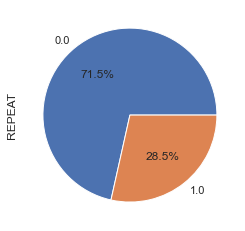

In [28]:
# first, see the distribution of `REPEAT`
rpt = df['REPEAT'].value_counts()
rpt.plot(kind='pie', autopct='%1.1f%%')

In [6]:
# extract the data of `REPEAT`
final_rpt = pd.DataFrame(df['REPEAT'], columns=['REPEAT'])
final_rpt_np = final_rpt.to_numpy()

In [7]:
# make new dataframe from old dataframe according to index_list
def turn_to_list(str):
	begin, end = str.split('~')
	list = [int(i) for i in range(int(begin), int(end)+1)]
	return list

def make_df(df, index_list, add_repeat = False):
	df_new = pd.DataFrame()
	for i in range(len(index_list)):
		index = index_list[i]
		if(type(index) == int):
			col = df.columns[index]
		else:
			col = index
		df_new[col] = df[col]
	if(add_repeat):
		df_new['REPEAT'] = df['REPEAT']
	return df_new

In [8]:
# simple sum
def sum(df,name,mean = False):
	if(df.columns[-1] == 'REPEAT'):
		df.drop(columns=['REPEAT'], inplace=True)
	if(type(df) == pd.core.frame.DataFrame):
		df = df.to_numpy()
	long = len(df[0])
	df = np.sum(df, axis=1)
	if(mean):
		df = df/long
	df = pd.DataFrame(df, columns=[name])
	return df

In [9]:
# sum all the features with relation to `REPEAT` and standardlize the value
def sum_stdlz(map, df, name):
	if(type(df) == pd.core.frame.DataFrame):
		df = df.to_numpy()
	scaler = StandardScaler()
	pn = map.iloc[-2]
	sign = map.iloc[-1][0]
	for i in range(len(pn)-1):
		if(i==0):
			if(sign>0):
				temp = df[:,i]
			else:
				temp = -df[:,i]
		else:
			if ((pn[i]>0 and sign > 0)or(pn[i]<0 and sign < 0)):
				temp = temp + df[:,i]
			else:
				temp = temp - df[:,i]
	df_new = scaler.fit_transform(temp.reshape(-1,1))
	df_new_pd = pd.DataFrame(df_new).rename(columns={0: name})
	return df_new_pd

In [10]:
# draw corr hot map
def draw_corr_map(df,method='pearson'):
	map = df.corr(method=method)
	sns.heatmap(map, annot=True, cmap='coolwarm')
	return map

### 2. divide the features into several parts by hand

parent education: "n" 11 16

study environment: "01" 11 13~16 20 21

life quality:"01" 12 18 19 23-26 "n" 27-35

parent care: "01" 36-39

former rpt: "01" 48-50

study dif: "n": 52-54 "01":55 56

study ambi: "01" 57-64

cooper: "n": 65-72
peer: "01": 73-78

tchr: "01": 79-84

skip: "01": 90-92

schl phnmn1: "n": 116-120
schl phnmn2: "01": 121-129
schl phnmn3: "n": 130-146

sciudstd: "01": 161-165 171-188

sciists: "n": 147-153 166-170 189-197

#### IF the data is yes/no choice, decide to see the correaltion between it and REPEAT

#### ELSE decide to see the regress and box-plot of the data distribution


#### 2.1 PRNT_EDU

In [24]:
def plt_pie(df, index):
    x = df[df.columns[index]].value_counts()
    x.plot(kind='pie', autopct='%1.1f%%')

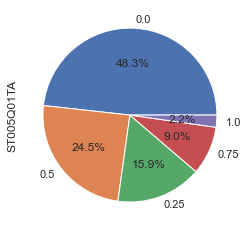

In [29]:
plt_pie(df, 1)

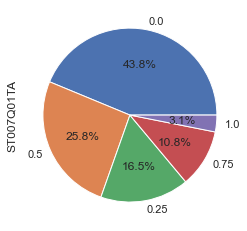

In [30]:
plt_pie(df, 6)

In [21]:
# we can see observe that the distribution of father and mother's education
# level is very similar, so we can mix them to form a new one
prnt_edu_pd = make_df(df,[1,6])
prnt_edu_np = prnt_edu_pd.to_numpy()
prnt_edu_np = np.sum(prnt_edu_np, axis=1)
PRNT_EDU = pd.DataFrame(prnt_edu_np, columns=['PRNT_EDU'])

In [22]:
prnt_edu_r = pd.concat([df['REPEAT'], PRNT_EDU], axis=1)

<AxesSubplot:xlabel='REPEAT', ylabel='PRNT_EDU'>

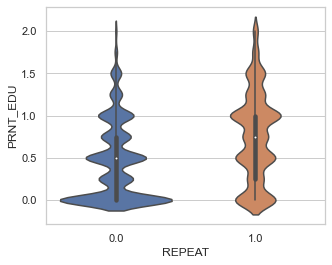

In [31]:
sns.violinplot(x='REPEAT', y='PRNT_EDU', data=prnt_edu_r)

Violinplot is a special type of boxplot, which can reveal the quantity density

#### 2.2 STDY_EVNRMNT

In [32]:
stdy_evrnmt_pd = make_df(df, [11] + turn_to_list('13~16') + [20,21])

In [33]:
stdy_evrnmt_np = stdy_evrnmt_pd.to_numpy()
stdy_evrnmt_np = np.sum(stdy_evrnmt_np, axis=1)
STDY_EVNRNMNT = pd.DataFrame(stdy_evrnmt_np, columns=['STDY_EVNRNMNT'])

In [34]:
stdy_evrnmt_r = pd.concat([df['REPEAT'], STDY_EVNRNMNT], axis=1)

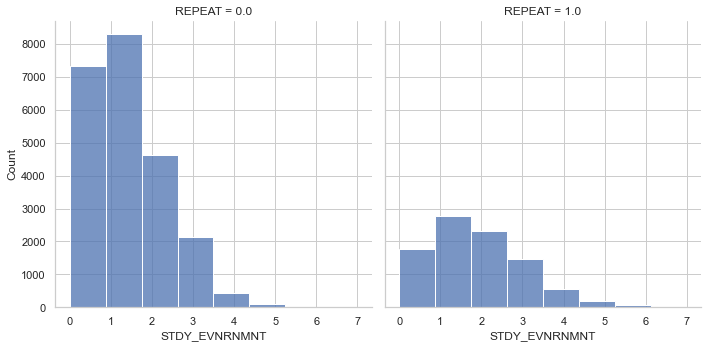

In [38]:
sns.displot(data = stdy_evrnmt_r, x='STDY_EVNRNMNT',bins=8,col='REPEAT')

Displot group by the value of 'col'

#### 2.3 LF_QLTY


In [39]:
lf_qlty_pd = make_df(df, [12,18,19] + turn_to_list('23~26') + turn_to_list('27~35'))

In [40]:
lf_qlty_np = lf_qlty_pd.to_numpy()
lf_qlty_np = np.sum(lf_qlty_np, axis=1)
LF_QLTY = pd.DataFrame(lf_qlty_np, columns=['LF_QLTY'])

In [41]:
lf_qlty_r = pd.concat([df['REPEAT'], LF_QLTY], axis=1)

<AxesSubplot:xlabel='LF_QLTY', ylabel='Count'>

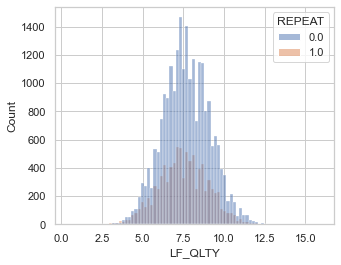

In [45]:
sns.histplot(data = lf_qlty_r, x='LF_QLTY',bins=80, hue='REPEAT')

Displot group by the value of 'hue'

#### 2.4 PRNT_CR

In [46]:
prnt_cr_pd = make_df(df, turn_to_list('36~39'))

#### 2.5 EX_RPT


In [47]:
ex_rpt_pd = make_df(df, [48,49,50])

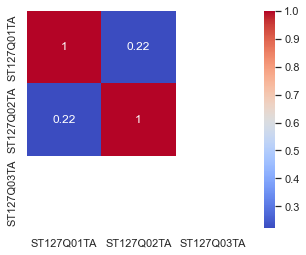

In [48]:
map = draw_corr_map(ex_rpt_pd)

In [49]:
# check the codebook
# 7 means "no answer"
# I guess that the students haven't reached level 3, therefore it's explained.

In [50]:
ex_rpt_pd = make_df(df, [48,49])

In [51]:
ex_rpt_np = ex_rpt_pd.to_numpy()
ex_rpt_np = np.sum(ex_rpt_np, axis=1)
EX_RPT = pd.DataFrame(ex_rpt_np, columns=['EX_RPT'])

In [52]:
ex_rpt_r = pd.concat([df['REPEAT'], EX_RPT], axis=1)

,REPEAT,EX_RPT
REPEAT,1.00000,0.91077
EX_RPT,0.91077,1.00000


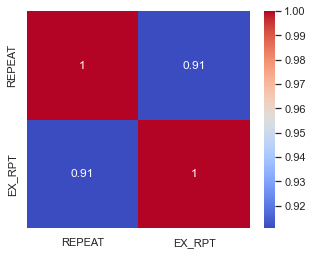

In [53]:
draw_corr_map(ex_rpt_r)

Corr and Heatmap

#### 2.6 STY

In [54]:
sty_pd = make_df(df, turn_to_list('52~64'), add_repeat = True)

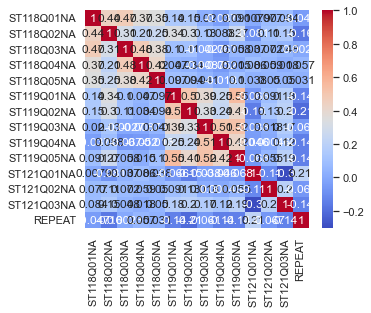

In [55]:
map = draw_corr_map(sty_pd)

In [56]:
STY = sum_stdlz(map, sty_pd, 'STY')

In [57]:
sty_r = pd.concat([df['REPEAT'], STY], axis=1)

<AxesSubplot:xlabel='STY', ylabel='Count'>

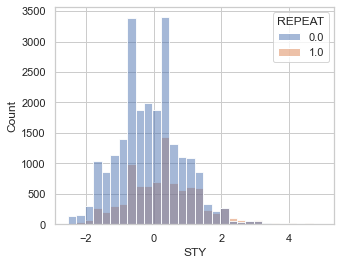

In [66]:
sns.histplot(data = sty_r, x='STY',bins=30, hue='REPEAT')

Heatmap + Histplot

#### 2.7 PEER

In [67]:
peer_pd = make_df(df, turn_to_list('73~78'), add_repeat = True)

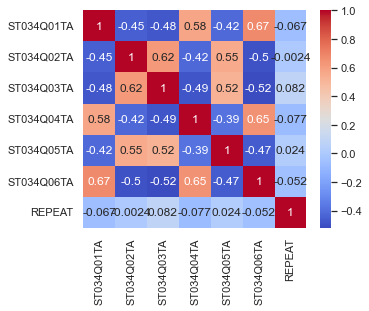

In [68]:
map = draw_corr_map(peer_pd, method='pearson')

In [69]:
PEER = sum_stdlz(map, peer_pd, 'PEER')

<AxesSubplot:xlabel='PEER', ylabel='Count'>

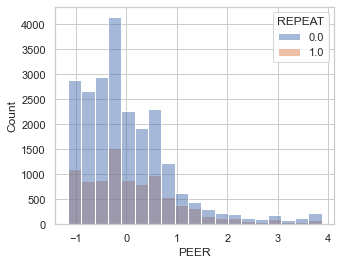

In [72]:
peer_r = pd.concat([df['REPEAT'], PEER], axis=1)
sns.histplot(data = peer_r, x='PEER',bins=19, hue='REPEAT')

#### 2.8 TCHR

In [73]:
tchr_pd = make_df(df, turn_to_list('79~84'), add_repeat = True)

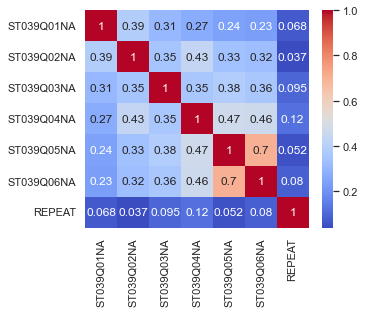

In [74]:
map = draw_corr_map(tchr_pd, method='pearson')

In [75]:
TCHR = sum_stdlz(map, tchr_pd, 'TCHR')

<AxesSubplot:xlabel='REPEAT', ylabel='TCHR'>

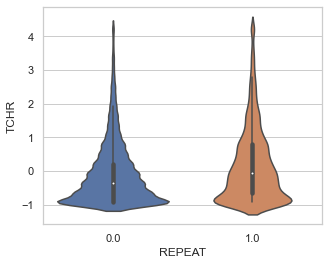

In [77]:
tchr_r = pd.concat([df['REPEAT'], TCHR], axis=1)
sns.violinplot(x='REPEAT', y='TCHR', data=tchr_r)

#### 2.9 SKIP

In [78]:
skip_pd = make_df(df, turn_to_list('90~92'), add_repeat = True)

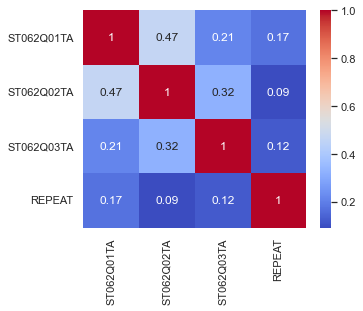

In [79]:
map = draw_corr_map(skip_pd, method='pearson')

In [80]:
SKIP = sum_stdlz(map, skip_pd, 'SKIP')

<AxesSubplot:xlabel='SKIP', ylabel='Count'>

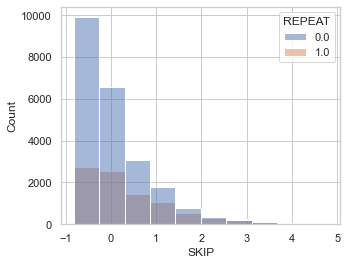

In [115]:
skip_r = pd.concat([df['REPEAT'], SKIP], axis=1)
sns.histplot(data = skip_r, x='SKIP',bins=10, hue='REPEAT')

#### 2.10.1 CLS1

In [84]:
cls1_pd = make_df(df, turn_to_list('116~120'), add_repeat = True)

In [85]:
CLS1 = sum(cls1_pd, 'CLS1')

<AxesSubplot:xlabel='CLS1', ylabel='Count'>

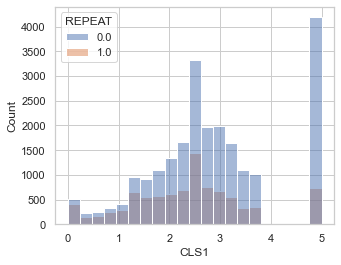

In [108]:
cls1_r = pd.concat([df['REPEAT'], CLS1], axis=1)
sns.histplot(data = cls1_r, x='CLS1',bins=21, hue='REPEAT')

the higher, the greater the class phenomenon is

#### 2.10.2 CLS2

In [96]:
cls2_pd = make_df(df, turn_to_list('121~129'), add_repeat = True)

In [97]:
CLS2 = sum(cls2_pd, 'CLS2')

<AxesSubplot:xlabel='CLS2', ylabel='Count'>

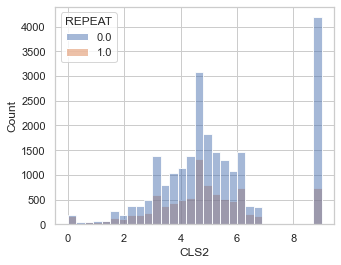

In [103]:
cls2_r = pd.concat([df['REPEAT'], CLS2], axis=1)
sns.histplot(data = cls2_r, x='CLS2',bins=30,hue='REPEAT')

#### 2.10.3 CLS3

In [116]:
cls3_pd = make_df(df, turn_to_list('130~146'), add_repeat = True)

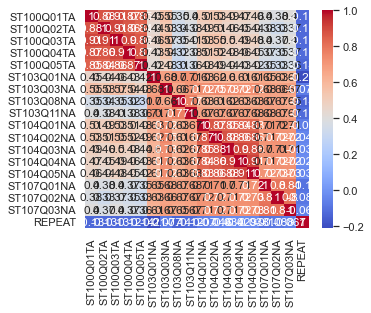

In [117]:
map = draw_corr_map(cls3_pd, method='pearson')

In [118]:
CLS3 = sum(cls3_pd, 'CLS3')

In [119]:
cls3_r = pd.concat([df['REPEAT'], CLS3], axis=1)

<AxesSubplot:xlabel='REPEAT', ylabel='CLS3'>

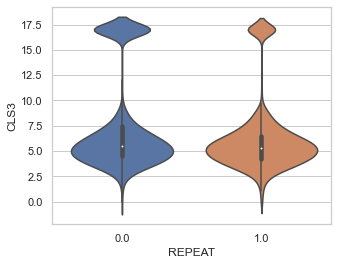

In [120]:
sns.violinplot(x='REPEAT', y='CLS3', data=cls3_r)

#### 2.11 KNLDG

In [121]:
knldg_pd = make_df(df, turn_to_list('304~403'), add_repeat = True)

C:\Users\x\AppData\Local\Temp\ipykernel_960\4069806483.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new['REPEAT'] = df['REPEAT']


In [122]:
KNLDG = sum(knldg_pd, 'KNLDG', mean=True)

In [123]:
knldg_r = pd.concat([df['REPEAT'], KNLDG], axis=1)

<AxesSubplot:xlabel='REPEAT', ylabel='KNLDG'>

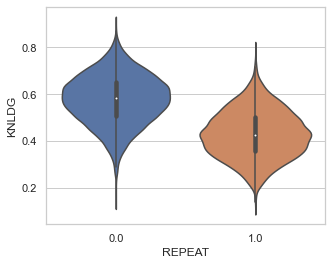

In [124]:
sns.violinplot(x='REPEAT', y='KNLDG', data=knldg_r)

<AxesSubplot:xlabel='KNLDG', ylabel='Count'>

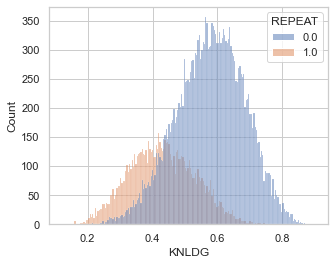

In [125]:
sns.histplot(data = knldg_r, x='KNLDG',bins=200, hue='REPEAT')

## Detailed analysis